# Introduction

In this notebook, we handle through pySpark, sql & ml, the featurization of an image collection stored on S3. <br/>
Aim is to build a scalable architecture to enable upcoming fast growth of the image collection keeping a viable computationnal time.

In [1]:
# spark
import findspark
findspark.init()
import pyspark
pyspark.__version__

'3.0.1'

In [2]:
# context & session
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [174]:
# data handling
from pyspark.sql.functions import col, element_at, split, input_file_name, pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [175]:
# ml tasks
from pyspark.ml.feature import PCA
from pyspark.ml.image import ImageSchema

In [176]:
# transform
from pyspark.ml.linalg import Vectors, VectorUDT

In [5]:
# usefull packages
import pandas as pd
import numpy as np
import time
import os
import io
# deal with image
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# core featurizer
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
tf.__version__

'2.4.0'

In [131]:
# cloud
import boto.s3
import boto3

In [132]:
import s3fs

#### time monitoring

In [8]:
start = time.perf_counter()
stop = time.perf_counter()
print(f'process, elapsed time: {stop - start:0.2f}s')

process, elapsed time: 0.00s


#### local home path 

In [9]:
from pathlib import Path
home = str(Path.home())
home

'/home/etienne'

# Cloud: Connect to S3 storage bucket & Check

In [142]:
# thanks to the proper set of .aws folder, nb ensure right permissions
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

oc-p8-fruits-storage


In [143]:
# get a handle on the bucket that holds your file
bucket = s3.Bucket('oc-p8-fruits-storage')

In [144]:
bucket

s3.Bucket(name='oc-p8-fruits-storage')

# Original upload of images into storage Bucket

In [11]:
# bulk rename to remove spaces out of folders name
# rational : spark.read.format("image").load(path) requires no space in path
# warning : do not apply until checking the parent location
def rename_folders(parent):
    for path, folders, _ in os.walk(parent):
        for i in range(len(folders)):
            new_name = folders[i].replace(' ', '_')
            os.rename(os.path.join(path, folders[i]), os.path.join(path, new_name))
            folders[i] = new_name
# only one time
# rename_folders('Inputs/Training')
# upload S3 through awscli : aws s3 cp Inputs s3://oc-p8-fruits-storage/ --recursive

# Spark session

In [84]:
spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()
sc = spark.sparkContext

In [85]:
spark

# Build a DataFrame like object with 1-D image vectors as Rows, Labeled

In [146]:
# from local path
# parent = '/mnt/c/users/etien/datascience/p8/inputs/subsample/**'
# from S3
path = "s3a://oc-p8-fruits-storage/Sample/**"


#### Explore through Spark Dataframe with 'image' format
nb this format appears to be irrelevant once trying to read binary contents, see below the alternate technique to build Spark Dataframe.

In [147]:
# build the spark_df, with explicit path stored for further use 
def load_img(path):
    ''' building of a spark df out of a spark.read.load of images + label extraction'''
    # monitor time
    start = time.perf_counter()
    # image load
    df_img = spark.read.format('image').load(path) # remove spaces of folder's name first
    print('images loaded')
    # store image path - in image.origin
    # df_img = df_img.withColumn('path', input_file_name())
    print('path stored')
    # extract labels
    df_img = df_img.withColumn('label', element_at(split(df_img['image.origin'], "/"), -2))
    print('labels extracted')
    stop = time.perf_counter()
    print(f'spark loader, elapsed time: {stop - start:0.2f}s')
    return df_img

In [148]:
# load images and extract labels
spark_df = load_img(parent)

images loaded
path stored
labels extracted
spark loader, elapsed time: 0.08s


In [89]:
start = time.perf_counter()
spark_df.show(5, True)
stop = time.perf_counter()
print(f'show - max 5 items, elapsed time: {stop - start:0.2f}s')

+--------------------+--------+
|               image|   label|
+--------------------+--------+
|[file:///mnt/c/us...|     Fig|
|[file:///mnt/c/us...|     Fig|
|[file:///mnt/c/us...|     Fig|
|[file:///mnt/c/us...|     Fig|
|[file:///mnt/c/us...|Eggplant|
+--------------------+--------+
only showing top 5 rows

show - max 5 items, elapsed time: 0.32s


In [90]:
spark_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)



In [91]:
spark_df.select(
    'image.origin',
    'image.height',
    'image.width',
    'image.nChannels',
    'image.mode',
    'image.data',
    'label'
).show(5, True)

+--------------------+------+-----+---------+----+--------------------+--------+
|              origin|height|width|nChannels|mode|                data|   label|
+--------------------+------+-----+---------+----+--------------------+--------+
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FE FF FF FE F...|     Fig|
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FF FF FF FF F...|     Fig|
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FF FF FF FF F...|     Fig|
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FF FF FF FF F...|     Fig|
|file:///mnt/c/use...|   100|  100|        3|  16|[FF FF FF FF FF F...|Eggplant|
+--------------------+------+-----+---------+----+--------------------+--------+
only showing top 5 rows



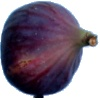

In [92]:
# show the first image
# note that we need to get a bytearray from image.data
Image.fromarray(
    np.array(
        spark_df.first().asDict()['image']['data']
    ).reshape(100, 100, 3)[:, :, ::-1])

In [93]:
# get memory_usage
# if large, use only fraction for rough approximation with: sample = spark_df.sample(fraction = 0.01)
start = time.perf_counter()
pdf = spark_df.select('image.data', 'label').toPandas()
stop = time.perf_counter()
print(f'conversion to Pandas, elapsed time: {stop - start:0.2f}s')
pdf.info(verbose=False, memory_usage="deep")

conversion to Pandas, elapsed time: 0.17s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 2 entries, data to label
dtypes: object(2)
memory usage: 235.5 KB


In [94]:
pdf.head(5)

,data,label
0,"[255, 254, 255, 255, 254, 255, 255, 255, 254, ...",Fig
1,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Fig
2,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Fig
3,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Fig
4,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Eggplant


#### Alternate image load - to handle the binary data

In [149]:
# alternate image load
def load_bin(path):
    start = time.perf_counter()
    df_bin = spark.read.format("binaryFile") \
      .option("pathGlobFilter", "*.jpg") \
      .option("recursiveFileLookup", "true") \
      .load(path)
    print('images loaded')
    # extract labels
    df_bin = df_bin.withColumn('label', element_at(split(df_bin['path'], "/"), -2))
    print('labels extracted')
    stop = time.perf_counter()
    print(f'process, elapsed time: {stop - start:0.2f}s')
    return df_bin

In [150]:
images = load_bin(parent)

images loaded
labels extracted
process, elapsed time: 0.06s


In [97]:
images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



In [98]:
images.show(5, True)

+--------------------+-------------------+------+--------------------+--------+
|                path|   modificationTime|length|             content|   label|
+--------------------+-------------------+------+--------------------+--------+
|file:/mnt/c/users...|2020-12-28 22:48:07|  4921|[FF D8 FF E0 00 1...|     Fig|
|file:/mnt/c/users...|2020-12-28 22:48:08|  4771|[FF D8 FF E0 00 1...|     Fig|
|file:/mnt/c/users...|2020-12-28 22:48:05|  4498|[FF D8 FF E0 00 1...|     Fig|
|file:/mnt/c/users...|2020-12-28 22:48:06|  4368|[FF D8 FF E0 00 1...|     Fig|
|file:/mnt/c/users...|2020-12-28 22:48:04|  4081|[FF D8 FF E0 00 1...|Eggplant|
+--------------------+-------------------+------+--------------------+--------+
only showing top 5 rows



In [156]:
# original processing for comparison
path_parent = '/mnt/c/users/etien/datascience/p8/inputs/subsample' 
# parse the folders and files in parent
df_collect = pd.DataFrame()
start = time.perf_counter()
for path, folders, files in os.walk(path_parent):
        # check if no subfolders
        if folders==[]:
            # label
            label = os.path.basename(path)
            # image
            for f in files:
                row_sample = np.asarray(
                    Image.open(
                        os.path.join(
                            path,
                            f
                        ))).ravel()
                df_sample = pd.DataFrame(row_sample).T
                df_sample.insert(0, 'label', label)
                df_collect = df_collect.append(df_sample, ignore_index=True)
stop = time.perf_counter()
print(f'old fashion way, elapsed time: {stop - start:0.2f}s')

old fashion way, elapsed time: 0.00s


In [157]:
df_collect.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [158]:
df_collect.head(3)

""


# Use of a CNN as feature extractor

https://docs.microsoft.com/zh-tw/azure/databricks/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [102]:
# model for featurization, last layers truncated.
# nb. spark workers need to access the model and its weights
conv_base = VGG16(
    include_top=False,
    weights=None,
    input_shape=(100, 100, 3))

In [103]:
# verify that the top layer is removed
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [104]:
# get weights
conv_base_weights = sc.broadcast(conv_base.get_weights())

In [105]:
# set weights 
# conv_base.set_weights(conv_base_weights.value)

In [106]:
# make conv_base callable
def conv_base_init():
    # returns a VGG 16 model with top layer removed and broadcasted weights
    conv_base = VGG16(
        include_top=False,
        weights=None,
        input_shape=(100, 100, 3))
    # error if sparkcontext as it will be called on workers and not only drivers
    # conv_base_weights = sc.broadcast(conv_base.get_weights())
    conv_base.set_weights(conv_base_weights.value)
    return conv_base

# Featurizer

#### Define image loading and featurization logic in a Pandas UDF
This notebook defines the logic in steps, building up to the Pandas UDF. 
The call stack is:
- pandas UDF
    - featurize a pd.Series of images
        - preprocess one image
        
This notebook uses the newer Scalar Iterator pandas UDF to amortize the cost of loading large models on workers.

#### ! control shape of constructed array

In [107]:
# get keras preprocess_input()
# create array from binary data
def get_preprocess(data):
    image = Image.open(io.BytesIO(data))
    array = img_to_array(image)
    return preprocess_input(array)

In [108]:
def featurize_series(conv_base, data_as_series):
    # serialization of conv_base.predict : featurize a pd.Series of raw images using the conv_base
    input = np.stack(
            data_as_series.map(
                get_preprocess
            ))
    features = conv_base.predict(input)
    # flatten the feature tensors to vectors (easier storage within Spark DataFrames)
    features_flat = [p.flatten() for p in features]
    return pd.Series(features_flat)

In [109]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize(data):
    # pandas user defined function to make operation on dataframe with pyspark.sql
    conv_base = conv_base_init()
    for data_as_series in data:
        yield featurize_series(conv_base, data_as_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [110]:
# udf_featurize = udf(featurize, 'array<float>')

#### ! need to catch the adequate repartition

In [111]:
images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



In [112]:
featurized_df = images.repartition(16).select(
    col('path'),
    col('label'),
    featurize('content').alias('vgg_features'))

In [113]:
featurized_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- vgg_features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [114]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [115]:
start = time.perf_counter()
featurized_df.show(5, True)
stop = time.perf_counter()
print(f'featurize, elapsed time: {stop - start:0.2f}s')

+--------------------+--------+--------------------+
|                path|   label|        vgg_features|
+--------------------+--------+--------------------+
|file:/mnt/c/users...|     Fig|[0.042368807, 0.0...|
|file:/mnt/c/users...|     Fig|[0.0, 0.099999145...|
|file:/mnt/c/users...|Eggplant|[0.0, 0.06892833,...|
|file:/mnt/c/users...|Eggplant|[0.040496692, 0.0...|
|file:/mnt/c/users...|     Fig|[0.0, 0.15701509,...|
+--------------------+--------+--------------------+
only showing top 5 rows

featurize, elapsed time: 15.37s


In [116]:
# get memory_usage
# if large, use only fraction for rough approximation with: sample = spark_df.sample(fraction = 0.01)
start = time.perf_counter()
pdf = featurized_df.select('path', 'label', 'vgg_features').toPandas()
stop = time.perf_counter()
print(f'conversion to Pandas, elapsed time: {stop - start:0.2f}s')
pdf.info(verbose=False, memory_usage="deep")

conversion to Pandas, elapsed time: 3.51s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Columns: 3 entries, path to vgg_features
dtypes: object(3)
memory usage: 326.4 KB


In [117]:
pdf.shape

(8, 3)

In [118]:
len(pdf.vgg_features[0])

4608

In [126]:
featurized_df

DataFrame[path: string, label: string, vgg_features: array<float>]

# Transform

In [179]:
# from Array to Vectors for PCA
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
vectorized_df = featurized_df.select(
    'path',
    'label',
    list_to_vector_udf(featurized_df["vgg_features"]).alias("vgg_vectors"))

In [180]:
vectorized_df.show(5, True)

+--------------------+--------+--------------------+
|                path|   label|         vgg_vectors|
+--------------------+--------+--------------------+
|file:/mnt/c/users...|     Fig|[0.04236880689859...|
|file:/mnt/c/users...|     Fig|[0.0,0.0999991446...|
|file:/mnt/c/users...|Eggplant|[0.0,0.0689283311...|
|file:/mnt/c/users...|Eggplant|[0.04049669206142...|
|file:/mnt/c/users...|     Fig|[0.0,0.1570150852...|
+--------------------+--------+--------------------+
only showing top 5 rows



In [181]:
vectorized_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- vgg_vectors: vector (nullable = true)



# Reduce

In [ ]:
# reduce with PCA - dimension to refine according to classification purpose
my_pca = PCA(k=16, inputCol="vgg_vectors", outputCol="pcaFeatures")
my_model = my_pca.fit(vectorized_df)
my_model.explainedVariance

In [ ]:
# apply pca reduction
results_df = my_model.transform(vectorized_df)

#### AWS S3 configuration

In [163]:
s3 = boto3.client('s3')
result = s3.get_bucket_acl(Bucket='oc-p8-fruits-storage')
print(result)

{'ResponseMetadata': {'RequestId': '37ABCF0F8ADB3B4E', 'HostId': 'PIVlEKhvLB0z2aK1fkdwXa1ydUzFqnrJvd9MURE+TKN0Hj6yMpcXVNFI/BMl1oFxkLXk0yLON9I=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'PIVlEKhvLB0z2aK1fkdwXa1ydUzFqnrJvd9MURE+TKN0Hj6yMpcXVNFI/BMl1oFxkLXk0yLON9I=', 'x-amz-request-id': '37ABCF0F8ADB3B4E', 'date': 'Wed, 13 Jan 2021 18:29:08 GMT', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 1}, 'Owner': {'ID': 'efc0d1f6df781e765ddecee33d630957f621d5acb562f763e8717286153cc073'}, 'Grants': [{'Grantee': {'ID': 'efc0d1f6df781e765ddecee33d630957f621d5acb562f763e8717286153cc073', 'Type': 'CanonicalUser'}, 'Permission': 'FULL_CONTROL'}]}


In [168]:
featurized_df

DataFrame[path: string, label: string, vgg_features: array<float>]

In [199]:
conf = SparkConf()
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:2.7.2')

In [204]:
# write remote
start = time.perf_counter()
featurized_df.write.parquet("s3://oc-p8-fruits-storage/Output/featurized_sample",mode="overwrite")
stop = time.perf_counter()
print(f'write remote, elapsed time: {stop - start:0.2f}s')

Py4JJavaError: An error occurred while calling o584.parquet.
: java.io.IOException: No FileSystem for scheme: s3
	at org.apache.hadoop.fs.FileSystem.getFileSystemClass(FileSystem.java:2660)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:2667)
	at org.apache.hadoop.fs.FileSystem.access$200(FileSystem.java:94)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:2703)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:2685)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:373)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:295)
	at org.apache.spark.sql.execution.datasources.DataSource.planForWritingFileFormat(DataSource.scala:459)
	at org.apache.spark.sql.execution.datasources.DataSource.planForWriting(DataSource.scala:559)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:399)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:288)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:848)
	at sun.reflect.GeneratedMethodAccessor338.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
# write local results on parquet file
start = time.perf_counter()
results_df.write.mode('overwrite').parquet('/mnt/c/users/etien/datascience/p8/outputs/featurized_sample')
stop = time.perf_counter()
print(f'write local, elapsed time: {stop - start:0.2f}s')

In [192]:
# read remote results from parquet file
start = time.perf_counter()
pd_results_df = pd.read_parquet('s3://oc-p8-fruits-storage/Output/featurized_sample', engine='pyarrow')
stop = time.perf_counter()
print(f'read remote, elapsed time: {stop - start:0.2f}s')

read local, elapsed time: 2.58s


In [187]:
# read local results from parquet file
start = time.perf_counter()
pd_results_df = pd.read_parquet('/mnt/c/users/etien/datascience/p8/outputs/featurized_sample', engine='pyarrow')
stop = time.perf_counter()
print(f'read local, elapsed time: {stop - start:0.2f}s')

read local, elapsed time: 1.44s


In [47]:
pd_results_df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 3 entries, path to vgg_features
dtypes: object(3)
memory usage: 442.0 bytes


In [48]:
results_df.head(5)

,path,label,vgg_features
0,file:/mnt/c/users/etien/datascience/p8/inputs/...,Apple_Pink_Lady,"[0.008157561, 0.06465888, 0.21114805, 0.139609..."


In [49]:
len(results_df['vgg_features'][0])

4608

In [50]:
# Get back to the original spark dataframe
print(len(featurized_df.select('vgg_features').take(1)[0][0]))

4608


In [205]:
sc.stop()